# **The seventh in-class-exercise (20 points in total, 10/21/2020)**

Question description: In the last in-class-exercise (exercise-06), you collected the titles of 100 articles about data science, natural language processing, and machine learning. The 100 article titles will be used as the text corpus of this exercise. Perform the following tasks:

## (1) (8 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 1.4MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=b2e53e76d93f8f0b7180bddb61ed3a85a023ec83805fe2b27bdcdef9bb81cd6b
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [2]:
# Write your code here
import pandas as pd
import nltk
import os.path
# NLTK Stop words
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from textblob import Word
nltk.download('wordnet')
from nltk.stem import PorterStemmer
st = PorterStemmer()
# spacy for lemmatization
import spacy
import re
import numpy as np
from pprint import pprint
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
df = pd.read_csv('/content/titles.csv')
df.head()

,Titles
0,Foundations of statistical natural language pr...
1,Natural language processing with Python: analy...
2,The Stanford CoreNLP natural language processi...
3,Handbook of natural language processing
4,Natural language processing (almost) from scratch


In [4]:
# Write your code here

#1 Noise removal
df['Titles'] = df['Titles'].replace('\n','',regex = True)
df['Titles'] = df['Titles'].replace('[^\w\s]','',regex = True)

#2 Remove numbers
df['Titles'] = df['Titles'].str.replace('\d+','')
df['Titles'] = df['Titles'].str.replace('\d+','')
#3 Remove StopWords
stop_Words = ["i", "me", "my", "myself", "we", "our", "ours", 
              "ourselves", "you", "your", "yours", "yourself",
              "yourselves", "he", "him", "his", "himself", "she", "her",
              "hers", "herself", "it", "its", "itself", "they", "them",
              "their", "theirs", "themselves", "what", "which", "who",
              "whom", "this", "that", "these", "those", "am", "is",
              "are", "was", "were", "be", "been", "being", "have",
              "has", "had", "having", "do", "does", "did", "doing",
              "a", "an", "the", "and", "but", "if", "or", "because",
              "as", "until", "while", "of", "at", "by", "for", "with",
              "about", "against", "between", "into", "through",
              "during", "before", "after", "above", "below", "to",
              "from", "up", "down", "in", "out", "on", "off", "over",
              "under", "again", "further", "then", "once", "here",
              "there", "when", "where", "why", "how", "all", "any",
              "both", "each", "few", "more", "most", "other", "some",
              "such", "no", "nor", "not", "only", "own", "same", "so",
              "than", "too", "very", "s", "t", "can", "will", "just",
              "don", "should", "now"]
# stop = stopwords.words('english')
df['Titles'] = df['Titles'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_Words))
#4 Lowercase all text
df['Titles'] = df['Titles'].str.lower()
#5 Stemming
df['Titles'] = df['Titles'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
#6 Lemmatization
df['Titles']=df['Titles'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [5]:
df.head()

,Titles
0,foundat statist natur languag process
1,natur languag process python analyz text natur...
2,the stanford corenlp natur languag process too...
3,handbook natur languag process
4,natur languag process almost scratch


In [6]:
data = df.Titles.values.tolist()

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[:1])

[['foundat', 'statist', 'natur', 'languag', 'process']]


In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=2) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=2)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example

print(trigram_mod[bigram_mod[data_words[1]]])

['natur_languag_process', 'python', 'analyz', 'text', 'natur_languag', 'toolkit']


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [9]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
  """https://spacy.io/api/annotation"""
  texts_out = []
  for sent in texts:
      doc = nlp(" ".join(sent)) 
      texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
  return texts_out

In [10]:
data_words_trigrams = make_trigrams(data_words)
data_words_bigrams = make_bigrams(data_words)

In [11]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])


In [12]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_trigrams = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized_bigrams = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized_bigrams[:10])

[['process'], ['process', 'text', 'toolkit'], ['corenlp', 'process', 'toolkit'], ['process'], ['process', 'almost', 'scratch'], ['approach', 'process'], ['process'], ['read', 'process'], ['recent', 'trend', 'deep', 'learn', 'base', 'process'], ['process', 'deep', 'neural', 'network', 'multitask', 'learn']]


In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized_bigrams)

# Create Corpus
texts = data_lemmatized_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1)]]


In [14]:
id2word[0]

'process'

In [15]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:10]]

[[('process', 1)],
 [('process', 1), ('text', 1), ('toolkit', 1)],
 [('process', 1), ('toolkit', 1), ('corenlp', 1)],
 [('process', 1)],
 [('process', 1), ('almost', 1), ('scratch', 1)],
 [('process', 1), ('approach', 1)],
 [('process', 1)],
 [('process', 1), ('read', 1)],
 [('process', 1),
  ('base', 1),
  ('deep', 1),
  ('learn', 1),
  ('recent', 1),
  ('trend', 1)],
 [('process', 1),
  ('deep', 1),
  ('learn', 1),
  ('multitask', 1),
  ('network', 1),
  ('neural', 1)]]

In [16]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=100, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(11,
  '0.008*"related" + 0.008*"modular" + 0.008*"thereof" + 0.008*"comput" + '
  '0.008*"handbook" + 0.008*"linguist" + 0.008*"medicin" + 0.008*"kind" + '
  '0.008*"record" + 0.008*"problem"'),
 (36,
  '0.008*"related" + 0.008*"modular" + 0.008*"thereof" + 0.008*"comput" + '
  '0.008*"handbook" + 0.008*"linguist" + 0.008*"medicin" + 0.008*"kind" + '
  '0.008*"record" + 0.008*"problem"'),
 (87,
  '0.008*"related" + 0.008*"modular" + 0.008*"thereof" + 0.008*"comput" + '
  '0.008*"handbook" + 0.008*"linguist" + 0.008*"medicin" + 0.008*"kind" + '
  '0.008*"record" + 0.008*"problem"'),
 (9,
  '0.008*"related" + 0.008*"modular" + 0.008*"thereof" + 0.008*"comput" + '
  '0.008*"handbook" + 0.008*"linguist" + 0.008*"medicin" + 0.008*"kind" + '
  '0.008*"record" + 0.008*"problem"'),
 (75,
  '0.008*"related" + 0.008*"modular" + 0.008*"thereof" + 0.008*"comput" + '
  '0.008*"handbook" + 0.008*"linguist" + 0.008*"medicin" + 0.008*"kind" + '
  '0.008*"record" + 0.008*"problem"'),
 (13,
  '0.008*"

In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.498916633654295

Coherence Score:  0.6806093326364346


In [41]:
# Visualize the topics
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
89     0.335226 -0.079134       1        1  4.112397
60    -0.351475 -0.059906       2        1  3.675375
2      0.305976 -0.199599       3        1  3.247624
57    -0.052491 -0.387932       4        1  3.214145
42     0.111412 -0.362740       5        1  3.198078
...         ...       ...     ...      ...       ...
56    -0.025752  0.140850      96        1  0.205696
58    -0.025752  0.140850      97        1  0.205696
59    -0.025752  0.140850      98        1  0.205696
61    -0.025752  0.140850      99        1  0.205696
0     -0.025752  0.140850     100        1  0.205696

[100 rows x 5 columns], topic_info=        Term       Freq      Total  Category  logprob  loglift
0    process  74.000000  74.000000   Default  30.0000  30.0000
44    system  12.000000  12.000000   Default  29.0000  29.0000
19       use   8.000000   8.000000   Default  28.0000  

In [22]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2020-10-23 11:40:09--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  4.67MB/s    in 3.3s    

2020-10-23 11:40:13 (4.67 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [23]:
import os
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=100, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [24]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized_bigrams, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

/usr/local/lib/python3.6/dist-packages/gensim/models/wrappers/ldamallet.py:442: RuntimeWarning: invalid value encountered in true_divide
  topic = topic / topic.sum()  # normalize to probability dist
/usr/local/lib/python3.6/dist-packages/gensim/models/wrappers/ldamallet.py:373: RuntimeWarning: invalid value encountered in true_divide
  return topics / topics.sum(axis=1)[:, None]


[(9,
  [('system', 0.6),
   ('corenlp', 0.2),
   ('appli', 0.2),
   ('related', 0.0),
   ('pdp', 0.0),
   ('handbook', 0.0),
   ('linguist', 0.0),
   ('medicin', 0.0),
   ('thereof', 0.0),
   ('record', 0.0)]),
 (54,
  [('related', nan),
   ('modular', nan),
   ('thereof', nan),
   ('comput', nan),
   ('handbook', nan),
   ('linguist', nan),
   ('medicin', nan),
   ('kind', nan),
   ('record', nan),
   ('problem', nan)]),
 (80,
  [('related', nan),
   ('modular', nan),
   ('thereof', nan),
   ('comput', nan),
   ('handbook', nan),
   ('linguist', nan),
   ('medicin', nan),
   ('kind', nan),
   ('record', nan),
   ('problem', nan)]),
 (23,
  [('datum', 0.5),
   ('employ', 0.5),
   ('related', 0.0),
   ('comput', 0.0),
   ('handbook', 0.0),
   ('linguist', 0.0),
   ('medicin', 0.0),
   ('predict', 0.0),
   ('modular', 0.0),
   ('record', 0.0)]),
 (63,
  [('neural', 0.6666666666666666),
   ('featur', 0.16666666666666666),
   ('opinion', 0.16666666666666666),
   ('medicin', 0.0),
   ('modu

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized_bigrams, start=2, limit=100, step=6)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/models/wrappers/ldamallet.py:373: RuntimeWarning: invalid value encountered in true_divide
  return topics / topics.sum(axis=1)[:, None]


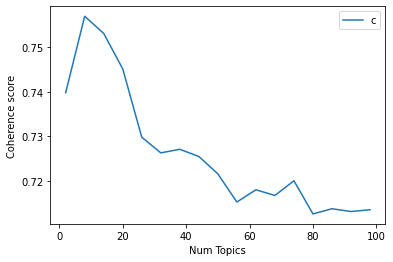

In [27]:
# Show graph
limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [28]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.7398
Num Topics = 8  has Coherence Value of 0.757
Num Topics = 14  has Coherence Value of 0.7532
Num Topics = 20  has Coherence Value of 0.7452
Num Topics = 26  has Coherence Value of 0.7298
Num Topics = 32  has Coherence Value of 0.7263
Num Topics = 38  has Coherence Value of 0.7271
Num Topics = 44  has Coherence Value of 0.7255
Num Topics = 50  has Coherence Value of 0.7216
Num Topics = 56  has Coherence Value of 0.7152
Num Topics = 62  has Coherence Value of 0.718
Num Topics = 68  has Coherence Value of 0.7167
Num Topics = 74  has Coherence Value of 0.72
Num Topics = 80  has Coherence Value of 0.7125
Num Topics = 86  has Coherence Value of 0.7137
Num Topics = 92  has Coherence Value of 0.7131
Num Topics = 98  has Coherence Value of 0.7135


In [29]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.385*"process" + 0.231*"learn" + 0.077*"topic" + 0.077*"mental" + '
  '0.077*"disfluent" + 0.077*"network" + 0.077*"rescu" + 0.000*"answer" + '
  '0.000*"comput" + 0.000*"problem"'),
 (1,
  '0.828*"process" + 0.034*"deep" + 0.034*"kind" + 0.034*"report" + '
  '0.034*"document" + 0.034*"decis" + 0.000*"handbook" + 0.000*"linguist" + '
  '0.000*"medicin" + 0.000*"comput"'),
 (2,
  '0.429*"method" + 0.214*"review" + 0.071*"radiolog" + 0.071*"record" + '
  '0.071*"produc" + 0.071*"weather" + 0.071*"word" + 0.000*"handbook" + '
  '0.000*"modular" + 0.000*"comput"'),
 (3,
  '0.467*"process" + 0.067*"predict" + 0.067*"textual" + 0.067*"comput" + '
  '0.067*"programm" + 0.067*"select" + 0.067*"space" + 0.067*"present" + '
  '0.067*"handbook" + 0.000*"linguist"'),
 (4,
  '0.312*"semant" + 0.250*"learn" + 0.062*"rank" + 0.062*"object" + '
  '0.062*"deep" + 0.062*"introduct" + 0.062*"approach" + 0.062*"maximum" + '
  '0.062*"empir" + 0.000*"handbook"'),
 (5,
  '0.750*"process" + 0.050*"s

## (2) (8 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [30]:
from gensim.models import LsiModel

In [31]:
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r") as fin:
        for line in fin.readlines():
            text = line.strip()
            documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles

In [32]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [33]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [34]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [35]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [36]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [38]:

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Total Number of Documents: 101
[(0, '0.566*"process" + 0.562*"languag" + 0.562*"natur" + 0.097*"system" + 0.077*"use" + 0.067*"base" + 0.042*"method" + 0.038*"learn" + 0.038*"network" + 0.035*"inform"'), (1, '0.490*"system" + -0.383*"use" + 0.376*"base" + 0.301*"method" + -0.207*"interact" + -0.200*"speech" + -0.184*"interfac" + -0.174*"user" + -0.174*"recognit" + 0.145*"inform"'), (2, '0.508*"use" + 0.428*"system" + 0.248*"speech" + 0.207*"interfac" + 0.207*"recognit" + 0.207*"user" + 0.203*"method" + 0.191*"interact" + 0.176*"base" + 0.138*"input"'), (3, '0.553*"base" + 0.343*"learn" + 0.244*"speech" + -0.223*"system" + 0.187*"deep" + 0.181*"network" + -0.134*"extract" + 0.133*"studi" + 0.126*"interact" + -0.125*"sentiment"'), (4, '0.417*"inform" + 0.393*"retriev" + -0.305*"base" + 0.226*"network" + 0.189*"method" + 0.177*"interact" + 0.150*"interfac" + 0.142*"user" + 0.142*"recognit" + 0.141*"search"'), (5, '-0.333*"interact" + 0.270*"learn" + -0.245*"text" + 0.243*"use" + 0.214*"se

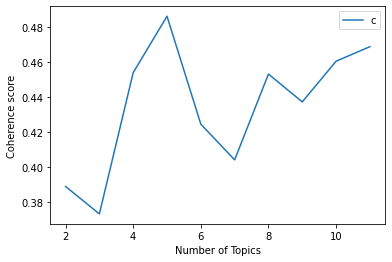

In [39]:
# LSA Model
number_of_topics=7
words=10
document_list,titles=load_data("/content","titles.csv")
clean_text=preprocess_data(document_list)
model=create_gensim_lsa_model(clean_text,number_of_topics,words)
start,stop,step=2,12,1
plot_graph(clean_text,start,stop,step)

## (3) (4 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

In [ ]:
# Write your answer here (no code needed for this question)

In [ ]:
"""
Definition "TOPIC MODELING":

Topic Modeling automatically discover the hidden themes from given documents.

It is an unsupervised text analytics algorithm that is used for finding the group of words from the given document.

These group of words represents a topic.

"""

In [ ]:
"""
TOPIC MODELING and TEXT CLASSIFICATION:

Topic modeling can be used to solve the text classification problem. 

Topic modeling will identify the topics presents in a document, while text classification classifies the text into a single class.
"""

In [ ]:
"""
TOPIC:

A topic is nothing but a collection of dominant keywords that are typical representatives.
Just by looking at the keywords, you can identify what the topic is all about.

How to have good Topics Arranged?

- The quality of text processing.
- The variety of topics the text talks about.
- The choice of topic modeling algorithm.
- The number of topics fed to the algorithm.
- The algorithms tuning parameters.

"""

In [ ]:
"""
Optimum Number of Topic Selection:

1. One way to determine the optimum number of topics is to consider each topic as a cluster

    and find out the effectiveness of a cluster using the Silhouette coefficient.

2. Topic coherence measure is a realistic measure for identifying the number of topics.

"""

In [ ]:
"""
USE CASES "TOPIC MODELING":

Resume Summarization: It can help recruiters to evaluate resumes by a quick glance. They can reduce effort in filtering pile of resume.

Search Engine Optimization: online articles, blogs, and documents can be tag easily by identifying the topics and associated keywords, which can improve optimize search results.

Recommender System Optimization: recommender systems act as an information filter and advisor according to the user profile and previous history. It can help us to discover unvisited relevant content based on past visits.

Improving Customer Support: Discovering relevant topics and associated keywords in customer complaints and feedback for examples product and service specifications, department, and branch details. Such information help company to directly rotated the complaint in respective department.

healthcare: In healthcare industry, topic modeling can help us to extract useful and valuable information from unstructured medical reports. This information can be used for patients treatment and medical science research purpose.

"""

In [ ]:
""" 
Coherence measure is a widely used metric to evaluate topic models

pyLDAvis, Matplotlib are used for interactive as well as 2D visualization of Topics and different coherence scores.

LDA and LSA both are Topic Modeling Techniques. I used Gensim for this, while in LDA, I acheived a coherence score of 
0.713 and by using LDA Mallet I got a little bit higher coherence score of 0.757.

In LSA model, The coherence score is in between 0.48 and 0.49, which is low compared to LDA models

Given fewer topics to to the model, coherence score is good in both LDA and LSA models.

LSA gives better results compared to the vector space model.

LSA involves document term matrix decomposition only

LSA is unable to capture the multiple meanings of words.

LSA offers lower accuracy than LDA.

LSA reduces Matrix dimension.

CONCLUSION:

LDA has upper hand over LSA, when coming to Topic Modeling. 

"""